In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

from due.dkl import DKL, GP, initial_values
from due.sngp import Laplace
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import os, sys
# import requests
# import h5py

from uci_datasets import Dataset

sns.set()
sns.set_palette("colorblind")

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = Dataset("bike")
x_train, y_train, x_test, y_test = data.get_split(split=9)

bike dataset, N=17379, d=17


In [7]:
x_train.shape

(15641, 17)

In [58]:
data = Dataset("keggdirected")
x_train, y_train, x_test, y_test = data.get_split(split=6)

keggdirected dataset, N=48827, d=20


In [228]:
data = Dataset("protein")
x_train, y_train, x_test, y_test = data.get_split(split=2)

protein dataset, N=45730, d=9


In [27]:
data = Dataset("concrete")
x_train, y_train, x_test, y_test = data.get_split(split=6)

concrete dataset, N=1030, d=8


In [8]:
x_train.shape, x_test.shape

((15641, 17), (1738, 17))

In [59]:
data = Dataset("keggdirected")
x_train, y_train, x_test, y_test = data.get_split(split=2)

keggdirected dataset, N=48827, d=20


In [238]:
data = Dataset("elevators")
x_train, y_train, x_test, y_test = data.get_split(split=0)

elevators dataset, N=16599, d=18


In [244]:
data = Dataset("pol")
x_train, y_train, x_test, y_test = data.get_split(split=0)

pol dataset, N=15000, d=26


In [561]:
data = Dataset("skillcraft")
x_train, y_train, x_test, y_test = data.get_split(split=9)

skillcraft dataset, N=3338, d=19


In [ ]:
df = df.astype(float)
Y = df["RMSD"].values.reshape(-1, 1)
X = df[["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9"]].values

In [ ]:
assert X.shape == (45730, 9)
assert Y.shape == (45730, 1)

In [ ]:
out_dir = "/Users/irwinchay/downloads"

protein_hdf_file = os.path.join(out_dir, 'protein.hdf5')
with h5py.File(protein_hdf_file, 'w') as hf: 
    dset = hf.create_dataset("X", data=X, dtype=np.float64, compression='gzip')
    dset = hf.create_dataset("Y", data=Y, dtype=np.float64, compression='gzip')

In [ ]:
# def make_data(n_samples, noise=0.05, seed=2):
#     # make some random sines & cosines
#     np.random.seed(seed)
#     n_samples = int(n_samples)
    
#     W = np.random.randn(30, 1)
#     b = np.random.rand(30, 1) * 2 * np.pi
    
#     x = 5 * np.sign(np.random.randn(n_samples)) + np.random.randn(n_samples).clip(-2, 2)
#     y = np.cos(W * x + b).sum(0) + noise * np.random.randn(n_samples)
#     return x[..., None], y

In [ ]:
# n_samples = 1e3
# # n_samples = 1e6

# domain = 15

# x, y = make_data(n_samples)
# plt.scatter(x, y)

In [26]:
x_train_real = x_train[:13903] #32000 # 2053   36584    36584     39063   13281    2672   # RE-RUN
y_train_real = y_train[:13903]
y_train_real = y_train_real.squeeze()
x_val = x_train[13903:]
y_val = y_train[13903:]
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [27]:
mean = x_train_real.mean(axis=0)
std = x_train_real.std(axis=0)

x_train_real_normalized = (x_train_real - mean) / std
x_val_normalized = (x_val - mean) / std
x_test_normalized = (x_test - mean) / std

In [163]:
x_train_real_normalized.shape

(36584, 9)

In [21]:
import torch.nn as nn

class IdentityMapping(nn.Module):
    def __init__(self):
        super(IdentityMapping, self).__init__()
    
    def forward(self, x):
        return x


In [6]:
from due.dkl_nn_test import GP_exp

In [166]:
for i in range(5):
    print(ds_train[i])

(tensor([ 1.0716,  0.1379, -1.2098,  0.9093,  1.0895,  0.9700,  0.4455, -0.8477,
        -1.1399]), tensor(-1.8912))
(tensor([-0.6996, -0.3178,  0.9663, -0.8416, -0.7707, -0.2433,  0.0480, -0.7594,
        -0.0202]), tensor(0.9737))
(tensor([ 1.1507,  0.4050, -0.8610,  1.7648,  1.1726,  1.5665,  0.5065,  1.2183,
        -1.3109]), tensor(-0.5134))
(tensor([ 2.8200,  1.8297, -0.5586,  3.3574,  2.7052,  2.4825,  1.3315,  3.8140,
        -2.6540]), tensor(-0.9630))
(tensor([ 1.7899,  1.1012, -0.5121,  2.2328,  1.8922,  1.9666,  0.7952,  0.4943,
        -2.0603]), tensor(-0.5702))


In [22]:
# np.random.seed(24)
# torch.manual_seed(24) ####################### CHANGE

# batch_size = 32

# # X_train, y_train = make_data(n_samples)
# # X_test, y_test = X_train, y_train

# # x_train, y_train, x_test, y_test

# ds_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train_real_normalized).float(), torch.from_numpy(y_train_real).float())
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True) # suffle 

# ds_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val_normalized).float(), torch.from_numpy(y_val).float())
# dl_val = torch.utils.data.DataLoader(ds_val, batch_size=32, shuffle=False)

# ds_test = torch.utils.data.TensorDataset(torch.from_numpy(x_test_normalized).float(), torch.from_numpy(y_test).float())
# dl_test = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=False)

# # steps = 5e3
# epochs = 50
# print(f"Training with {len(x_train_real)} datapoints for {epochs} epochs")

# # Change this boolean to False for SNGP

# input_dim = 17 # input di  # 128
# # features = 1024 # hidden    128
# # depth = 6   # 4  6
# num_outputs = 1 # regression with 1D output
# # spectral_normalization = True
# # coeff = 0.95
# # n_power_iterations = 1
# # dropout_rate = 0.01

# # feature_extractor = FCResNet(
# #     input_dim=input_dim, 
# #     features=features, 
# #     depth=depth, 
# #     spectral_normalization=spectral_normalization, 
# #     coeff=coeff, 
# #     n_power_iterations=n_power_iterations,
# #     dropout_rate=dropout_rate
# # )

# feature_extractor = IdentityMapping()

# n_inducing_points = 50
# kernel = "RBF" ################# change 

# initial_inducing_points, initial_lengthscale = initial_values(
#         ds_train, feature_extractor, n_inducing_points
# )

# gp = GP(
#     num_outputs=num_outputs,
#     num_features=input_dim,          # CHANGE features / input_dim
#     initial_lengthscale=initial_lengthscale,
#     initial_inducing_points=initial_inducing_points,
#     kernel=kernel,
#     # sm_kernel_mixtures=10, 
#     # sm_kernel_x_train=torch.tensor(x_train_real_normalized),
#     # sm_kernel_y_train=torch.tensor(y_train_real),
# )

# model = DKL(feature_extractor, gp)

# likelihood = GaussianLikelihood()
# elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
# loss_fn = lambda x, y: -elbo_fn(x, y)
    


# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()

# # learning rate   
# lr = 1e-3

# parameters = [
#     {"params": model.parameters(), "lr": lr},
# ]
# parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
# optimizer = torch.optim.Adam(parameters)
# pbar = ProgressBar()

# def step(engine, batch):
#     model.train()
#     likelihood.train()
    
#     optimizer.zero_grad()
    
#     x, y = batch
#     if torch.cuda.is_available():
#         x = x.cuda()
#         y = y.cuda()

#     y_pred = model(x) # get y
    
#     loss = loss_fn(y_pred, y) # loss
    
#     loss.backward()
#     optimizer.step()
    
#     return loss.item()


# def eval_step(engine, batch):
#     model.eval() # set to eval
#     likelihood.eval()
    
#     x, y = batch
#     if torch.cuda.is_available():
#         x = x.cuda()
#         y = y.cuda()

#     y_pred = model(x)    
#     return y_pred, y
  
# trainer = Engine(step)
# evaluator = Engine(eval_step)

# metric = Average()
# metric.attach(trainer, "loss")
# pbar.attach(trainer)


# metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())

# metric.attach(evaluator, "loss")

# @trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/20) + 1))
# def log_results(trainer):
#     evaluator.run(dl_val) # val dataset
#     print(f"Results - Epoch: {trainer.state.epoch} - "
#           f"Val Loss: {evaluator.state.metrics['loss']:.2f} - "
#           f"Train Loss: {trainer.state.metrics['loss']:.2f}")


Training with 13903 datapoints for 50 epochs
f_X_samples torch.Size([1000, 17])
initial_lengthscale tensor(5.6365)


/Users/irwinchay/opt/anaconda3/envs/cirkit1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [32]:
np.random.seed(24)
torch.manual_seed(24) ####################### CHANGE

batch_size = 32

# X_train, y_train = make_data(n_samples)
# X_test, y_test = X_train, y_train

# x_train, y_train, x_test, y_test

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train_real_normalized).float(), torch.from_numpy(y_train_real).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True) # suffle 

ds_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val_normalized).float(), torch.from_numpy(y_val).float())
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=32, shuffle=False)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(x_test_normalized).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=False)

# steps = 5e3
epochs = 50
print(f"Training with {len(x_train_real)} datapoints for {epochs} epochs")

# Change this boolean to False for SNGP

input_dim = 17 # input di  # 128
features = 128 # hidden    128
depth = 4   # 4  6
num_outputs = 1 # regression with 1D output
spectral_normalization = False
coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.01

feature_extractor = FCResNet(
    input_dim=input_dim, 
    features=features, 
    depth=depth, 
    spectral_normalization=spectral_normalization, 
    coeff=coeff, 
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
)

# feature_extractor = IdentityMapping()

n_inducing_points = 50
kernel = "HBF" ################# change 

initial_inducing_points, initial_lengthscale = initial_values(
        ds_train, feature_extractor, n_inducing_points
)

gp = GP(
    num_outputs=num_outputs,
    num_features=features,          # CHANGE features / input_dim
    initial_lengthscale=initial_lengthscale,
    initial_inducing_points=initial_inducing_points,
    kernel=kernel,
    # sm_kernel_mixtures=10, 
    # sm_kernel_x_train=torch.tensor(x_train_real_normalized),
    # sm_kernel_y_train=torch.tensor(y_train_real),
)

model = DKL(feature_extractor, gp)

likelihood = GaussianLikelihood()
elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
loss_fn = lambda x, y: -elbo_fn(x, y)
    


if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# learning rate   
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]
parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x) # get y
    
    loss = loss_fn(y_pred, y) # loss
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval() # set to eval
    likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)    
    return y_pred, y
  
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)


metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())

metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/20) + 1))
def log_results(trainer):
    evaluator.run(dl_val) # val dataset
    print(f"Results - Epoch: {trainer.state.epoch} - "
          f"Val Loss: {evaluator.state.metrics['loss']:.2f} - "
          f"Train Loss: {trainer.state.metrics['loss']:.2f}")


Training with 13903 datapoints for 50 epochs
f_X_samples torch.Size([1000, 128])
initial_lengthscale tensor(5.8117)


/Users/irwinchay/opt/anaconda3/envs/cirkit1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [33]:
for param in model.parameters():
    print (param.shape)

torch.Size([128])
torch.Size([128, 17])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([128, 128])
torch.Size([50, 128])
torch.Size([50])
torch.Size([50, 50])
torch.Size([1, 128])
torch.Size([1])
torch.Size([])


In [34]:
trainer.run(dl_train, max_epochs=epochs)

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 3 - Val Loss: 0.59 - Train Loss: 0.70


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 6 - Val Loss: 0.09 - Train Loss: 0.17


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 9 - Val Loss: -0.31 - Train Loss: -0.20


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 12 - Val Loss: -0.44 - Train Loss: -0.40


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 15 - Val Loss: -0.58 - Train Loss: -0.53


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 18 - Val Loss: -0.74 - Train Loss: -0.61


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 21 - Val Loss: -0.72 - Train Loss: -0.56


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 24 - Val Loss: -0.57 - Train Loss: -0.66


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 27 - Val Loss: -0.84 - Train Loss: -0.72


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 30 - Val Loss: -0.44 - Train Loss: -0.69


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 33 - Val Loss: -0.81 - Train Loss: -0.75


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 36 - Val Loss: -0.85 - Train Loss: -0.81


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 39 - Val Loss: -0.82 - Train Loss: -0.69


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 42 - Val Loss: -1.05 - Train Loss: -0.81


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 45 - Val Loss: -1.08 - Train Loss: -0.78


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

Results - Epoch: 48 - Val Loss: -1.06 - Train Loss: -0.85


[1/434]   0%|           [00:00<?]

[1/434]   0%|           [00:00<?]

State:
	iteration: 21700
	epoch: 50
	epoch_length: 434
	max_epochs: 50
	output: -1.038889765739441
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [35]:
from ignite.metrics import RootMeanSquaredError
import torch

# Assuming you have a function to compute RMSE, or you're using Ignite's RMSE metric

def eval_step(engine, batch):
    model.eval()  # Ensure model is in evaluation mode
    likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    # Assuming your model outputs a distribution, e.g., MultivariateNormal
    with torch.no_grad():  # Disable gradient computation for evaluation
        distribution = model(x)
        y_pred = distribution.mean  # Use the mean of the distribution as the prediction

    return y_pred, y

# Update the evaluator engine
evaluator = Engine(eval_step)

# Attach the RMSE metric to the evaluator
rmse = RootMeanSquaredError()
rmse.attach(evaluator, "RMSE")

# After training, run the evaluator on the test dataset to compute the RMSE
evaluator.run(dl_test)

# Retrieve and display the RMSE
test_rmse = evaluator.state.metrics['RMSE']
print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 0.08


# SM kernel 

In [304]:
data = Dataset("kin40k")
x_train, y_train, x_test, y_test = data.get_split(split=2)


kin40k dataset, N=40000, d=8


In [287]:
x_train.shape, x_test.shape

((36000, 8), (4000, 8))

In [305]:
x_train_real = x_train[:32000] #32000 # 2053   36584    36584     39063   13281    2672   # RE-RUN
y_train_real = y_train[:32000]
y_train_real = y_train_real.squeeze()
x_val = x_train[32000:]
y_val = y_train[32000:]
y_val = y_val.squeeze()
y_test = y_test.squeeze()


In [306]:
mean = x_train_real.mean(axis=0)
std = x_train_real.std(axis=0)

x_train_real_normalized = (x_train_real - mean) / std
x_val_normalized = (x_val - mean) / std
x_test_normalized = (x_test - mean) / std

In [307]:
np.random.seed(24)
torch.manual_seed(24) ####################### CHANGE

batch_size = 32

# X_train, y_train = make_data(n_samples)
# X_test, y_test = X_train, y_train

# x_train, y_train, x_test, y_test

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train_real_normalized).float(), torch.from_numpy(y_train_real).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True) # suffle 

ds_val = torch.utils.data.TensorDataset(torch.from_numpy(x_val_normalized).float(), torch.from_numpy(y_val).float())
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=512, shuffle=False)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(x_test_normalized).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=512, shuffle=False)

# steps = 5e3
epochs = 50
print(f"Training with {len(x_train_real)} datapoints for {epochs} epochs")

# Change this boolean to False for SNGP

input_dim = 8 # input di  # 128
# features = 1024 # hidden    128
# depth = 6   # 4  6
num_outputs = 1 # regression with 1D output
# spectral_normalization = True
# coeff = 0.95
# n_power_iterations = 1
# dropout_rate = 0.01

# feature_extractor = FCResNet(
#     input_dim=input_dim, 
#     features=features, 
#     depth=depth, 
#     spectral_normalization=spectral_normalization, 
#     coeff=coeff, 
#     n_power_iterations=n_power_iterations,
#     dropout_rate=dropout_rate
# )

feature_extractor = IdentityMapping()

n_inducing_points = 100
kernel = "SM" ################# change 

initial_inducing_points, initial_lengthscale = initial_values(
        ds_train, feature_extractor, n_inducing_points
)

# gp = GP(
#     num_outputs=num_outputs,
#     num_features=input_dim,          # CHANGE features / input_dim
#     initial_inducing_points=initial_inducing_points,
#     kernel=kernel,
#     initial_lengthscale=initial_lengthscale,
# )

gp = GP(
    num_outputs=num_outputs,
    num_features=input_dim,          # CHANGE features / input_dim
    initial_inducing_points=initial_inducing_points,
    kernel=kernel,
    initial_lengthscale=None,
    sm_kernel_mixtures = 30,
    sm_kernel_x_train = None, # torch.tensor(x_train_real_normalized), 
    sm_kernel_y_train = None, # torch.tensor(y_train_real),  
)

model = DKL(feature_extractor, gp)

likelihood = GaussianLikelihood()
elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
loss_fn = lambda x, y: -elbo_fn(x, y)
    


if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# learning rate   
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]
parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x) # get y
    
    loss = loss_fn(y_pred, y) # loss
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval() # set to eval
    likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)    
    return y_pred, y
  
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)


metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())

metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/20) + 1))
def log_results(trainer):
    evaluator.run(dl_val) # val dataset
    print(f"Results - Epoch: {trainer.state.epoch} - "
          f"Val Loss: {evaluator.state.metrics['loss']:.2f} - "
          f"Train Loss: {trainer.state.metrics['loss']:.2f}")


Training with 32000 datapoints for 50 epochs
f_X_samples torch.Size([1000, 8])
initial_lengthscale tensor(3.8970)


/Users/irwinchay/opt/anaconda3/envs/cirkit1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [308]:
for param in model.parameters():
    print (param.shape)

torch.Size([100, 8])
torch.Size([100])
torch.Size([100, 100])
torch.Size([30])
torch.Size([30, 1, 8])
torch.Size([30, 1, 8])
torch.Size([1])
torch.Size([])


In [309]:
trainer.run(dl_train, max_epochs=epochs)

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 3 - Val Loss: 1.11 - Train Loss: 1.23


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 6 - Val Loss: 0.61 - Train Loss: 0.73


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 9 - Val Loss: 0.25 - Train Loss: 0.26


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 12 - Val Loss: 0.20 - Train Loss: 0.20


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 15 - Val Loss: 0.18 - Train Loss: 0.16


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 18 - Val Loss: 0.11 - Train Loss: 0.11


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 21 - Val Loss: 0.08 - Train Loss: 0.08


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 24 - Val Loss: 0.04 - Train Loss: 0.06


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 27 - Val Loss: 0.05 - Train Loss: 0.05


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 30 - Val Loss: 0.04 - Train Loss: 0.04


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 33 - Val Loss: 0.03 - Train Loss: 0.04


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 36 - Val Loss: 0.02 - Train Loss: 0.03


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 39 - Val Loss: 0.05 - Train Loss: 0.01


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 42 - Val Loss: 0.01 - Train Loss: -0.00


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 45 - Val Loss: -0.00 - Train Loss: -0.01


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

Results - Epoch: 48 - Val Loss: -0.02 - Train Loss: -0.02


[1/1000]   0%|           [00:00<?]

[1/1000]   0%|           [00:00<?]

State:
	iteration: 50000
	epoch: 50
	epoch_length: 1000
	max_epochs: 50
	output: 0.1615297943353653
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

: 

In [303]:
from ignite.metrics import RootMeanSquaredError
import torch

# Assuming you have a function to compute RMSE, or you're using Ignite's RMSE metric

def eval_step(engine, batch):
    model.eval()  # Ensure model is in evaluation mode
    likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    # Assuming your model outputs a distribution, e.g., MultivariateNormal
    with torch.no_grad():  # Disable gradient computation for evaluation
        distribution = model(x)
        y_pred = distribution.mean  # Use the mean of the distribution as the prediction

    return y_pred, y

# Update the evaluator engine
evaluator = Engine(eval_step)

# Attach the RMSE metric to the evaluator
rmse = RootMeanSquaredError()
rmse.attach(evaluator, "RMSE")

# After training, run the evaluator on the test dataset to compute the RMSE
evaluator.run(dl_test)

# Retrieve and display the RMSE
test_rmse = evaluator.state.metrics['RMSE']
print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 0.21


# Test SM Kernel

In [262]:
from due.sm_kernel import SMKernel

x_1 = torch.rand((3, 9))
y_1 = torch.rand(3)
x_2 = torch.rand((3, 9))


sm_kernel = SMKernel(batch_shape=torch.Size([]), num_mixtures=4, ard_num_dims=9)
sm_kernel.initialize_from_data(x_1, y_1)

# sm_kernel.mixture_means.shape

sm_kernel(x_1, x_2).evaluate()

tensor([[ 0.0000e+00,  0.0000e+00, -7.3949e-16],
        [ 7.6457e-25,  0.0000e+00,  0.0000e+00],
        [-7.1090e-34,  0.0000e+00,  0.0000e+00]], grad_fn=<ViewBackward0>)

In [264]:
sigma = sm_kernel.mixture_scales.squeeze(1)
mu = sm_kernel.mixture_means.squeeze(1)
weights = sm_kernel.mixture_weights

def SMK(x1, x2, sigma, mu): 
    tau = x1-x2
    return torch.prod(torch.exp(-2*(torch.pi**2)* (tau**2)*(sigma**2) )) * torch.cos(2.0*torch.pi*torch.dot(tau,mu))

for i in range(x_1.shape[0]): 
    for j in range(x_2.shape[0]): 
        smk = []
        for k in range(sigma.shape[0]): 
            smk.append(weights[k] * SMK(x_1[i], x_2[j], sigma[k], mu[k]) )
        print(sum(smk))

tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(-7.3942e-16, grad_fn=<AddBackward0>)
tensor(7.6457e-25, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(-7.1090e-34, grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)
tensor(0., grad_fn=<AddBackward0>)


In [56]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Text(0.5, 1.0, 'Induced covariance matrix of HBF kernel')

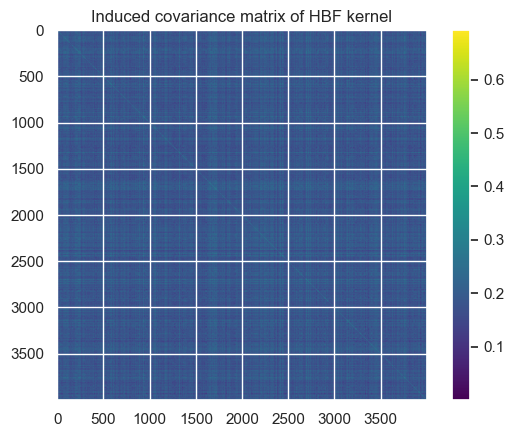

In [42]:
x_test_500 = x_test # [:500]
y_test_500 = y_test # [:500]

x_test_torch = torch.from_numpy(x_test_500).float()
y_test_torch = torch.from_numpy(y_test_500).float()

# sorted_indices = torch.argsort(y_test_torch)
# sorted_x_test_torch = x_test_torch[sorted_indices]
sorted_x_test_torch = x_test_torch

# sorted_x_test_torch = sorted_x_test_torch[:500]
# sorted_x_test_torch = sorted_x_test_torch[3500:]
# sorted_x_test_torch = sorted_x_test_torch[2000:2500]
# sorted_x_test_torch = x_test_torch

x_features = model.feature_extractor(sorted_x_test_torch)
cov_matrix = model.gp.get_covar(x_features).evaluate()

# Plot the induced covariance matrix
plt.imshow(cov_matrix.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Induced covariance matrix of HBF kernel")
# plt.savefig('HBF_cov.pdf')


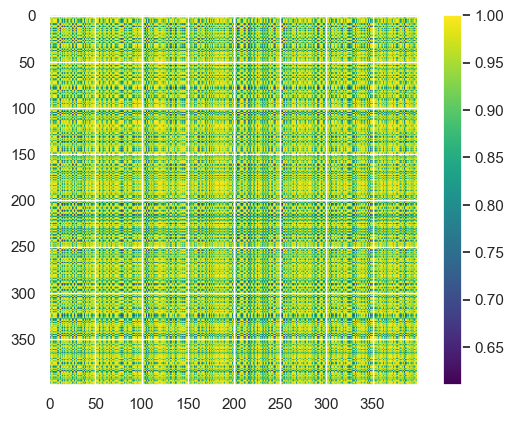

In [578]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_test and y_test are available as numpy arrays
# If they need to be loaded from a file, this would typically be done with numpy's loading functions.

# For the purpose of the example, let's create some dummy data
# np.random.seed(0)
# x_test = np.random.rand(400, 1) # 400 random data points
# y_test = np.random.rand(400) # 400 random target values

# Convert numpy arrays to torch tensors
x_test_torch = torch.from_numpy(x_test_500).float()
y_test_torch = torch.from_numpy(y_test_500).float()

# Sort x_test by the corresponding y_test values
sorted_indices = torch.argsort(y_test_torch)
sorted_x_test_torch = x_test_torch[sorted_indices]

# Placeholder for the model's covariance function
# In an actual use case, this would be replaced with the GP model's learned covariance function.
# def covariance_function(x1, x2):
#     # For demonstration, we'll use a simple squared exponential kernel
#     # In practice, this should be the kernel used by the GP model.
#     length_scale = 1.0
#     return torch.exp(-0.5 * ((x1 - x2) / length_scale).pow(2))



# Calculate the covariance matrix
cov_matrix = torch.zeros((100, 100), dtype=torch.float32)
for i in range(100):
    for j in range(100):
        
        cov_matrix[i, j] = covariance_function(sorted_x_test_torch[i], sorted_x_test_torch[j])

# Plot the induced covariance matrix
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()
plt.show()


In [591]:
from gpytorch.kernels import ScaleKernel


self.covar_module = ScaleKernel(covariance_function, batch_shape=100)



AttributeError: 'function' object has no attribute 'active_dims'

In [ ]:
plt.xlim(-domain, domain)
plt.ylim(-10, 10)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)

In [ ]:
plt.xlim(-domain, domain)

for i in range(1):
    plt.plot(x_lin, ol.rsample().cpu(), alpha=0.3, color='b')
    
plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=200)
plt.scatter(X_vis.squeeze(), y_vis, s=50)

In [ ]:
# Inspired by https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# only works on 1,000 samples

train_x, train_y = torch.tensor(x).float(), torch.tensor(y).float()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = GaussianLikelihood()
exact_gp = ExactGPModel(train_x, train_y, likelihood)

exact_gp.train()
likelihood.train()

optimizer = torch.optim.Adam(exact_gp.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, exact_gp)

training_iter = 100

for i in range(training_iter):
    optimizer.zero_grad()
    output = exact_gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        exact_gp.covar_module.base_kernel.lengthscale.item(),
        exact_gp.likelihood.noise.item()
    ))
    optimizer.step()

In [ ]:
exact_gp.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-domain, domain, 100)
    observed_pred = likelihood(exact_gp(test_x))


    output = observed_pred.mean
    output_std = observed_pred.stddev

plt.xlim(-domain, domain)
plt.fill_between(x_lin, output - output_std, output + output_std, alpha=0.2, color='b')
plt.fill_between(x_lin, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b')

plt.scatter([], [])
plt.scatter([], [])
X_vis, y_vis = make_data(n_samples=300)

plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(x_lin, output, alpha=0.5)